# Metabolic Syndrome Prediction

## 1. Load and Explore the Data

### Loading libraries

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [172]:
# Load the data
data = pd.read_csv('Metabolic Syndrome.csv')

# Display the first few rows of the dataset
data.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


### Columns transcript 

**seqn:** Unique identifier for each participant in the study.

**Age:** Age of the participant, measured in years.

**Income:** Annual income of the participant, likely represented in units of currency (e.g., dollars).

**WaistCirc:** Waist circumference of the participant, measured in centimeters (or inches depending on the dataset's standard).  

**BMI:** Body Mass Index of the participant, calculated as weight in kilograms divided by the square of height in meters (kg/m²).  

**Albuminuria:** Indicator of albumin levels in urine, used to assess kidney function. Typically a binary indicator (e.g., presence or absence of albuminuria).

**UrAlbCr:** Urinary Albumin-to-Creatinine Ratio, a measure used to detect kidney disease.

**UricAcid:** Uric acid levels in the participant's blood, measured in mg/dL.

**BloodGlucose:** Blood glucose level of the participant, measured in mg/dL.

**HDL:** High-Density Lipoprotein cholesterol level, measured in mg/dL, often referred to as "good" cholesterol.

**Triglycerides:** Level of triglycerides in the participant's blood, measured in mg/dL. High levels can increase the risk of heart disease.

**MetabolicSyndrome:** Binary variable indicating the presence (1) or absence (0) of metabolic syndrome in the participant.

**Sex_Male:** Binary variable indicating the sex of the participant, with 1 for male and 0 for female.

**Marital_Married:** Binary indicator where 1 represents that the participant is married and 0 otherwise.

**Marital_Separated:** Binary indicator where 1 represents that the participant is separated and 0 otherwise.

**Marital_Single:** Binary indicator where 1 represents that the participant is single and 0 otherwise.

**Marital_Widowed:** Binary indicator where 1 represents that the participant is widowed and 0 otherwise.

**Race_Black:** Binary indicator where 1 represents that the participant identifies as Black and 0 otherwise.

**Race_Hispanic:** Binary indicator where 1 represents that the participant identifies as Hispanic and 0 otherwise.

**Race_MexAmerican:** Binary indicator where 1 represents that the participant identifies as Mexican American and 0 otherwise.

**Race_Other:** Binary indicator where 1 represents that the participant identifies as a race other than those specifically listed and 0 otherwise.

**Race_White:** Binary indicator where 1 represents that the participant identifies as White and 0 otherwise.


## 2. Data Cleaning

In [173]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64


In [176]:
# Handle missing values
data['Marital'].fillna(data['Marital'].mode()[0], inplace=True)
data['Income'].fillna(data['Income'].median(), inplace=True)                 
data = data.dropna(subset=['BMI', 'WaistCirc'])

# Convert categorical variables to dummy/indicator variables
data = pd.get_dummies(data, columns=['Sex', 'Marital', 'Race'], drop_first=True)
# Check for any remaining missing values
data.isnull().sum()

seqn                 0
Age                  0
Income               0
WaistCirc            0
BMI                  0
Albuminuria          0
UrAlbCr              0
UricAcid             0
BloodGlucose         0
HDL                  0
Triglycerides        0
MetabolicSyndrome    0
Sex_Male             0
Marital_Married      0
Marital_Separated    0
Marital_Single       0
Marital_Widowed      0
Race_Black           0
Race_Hispanic        0
Race_MexAmerican     0
Race_Other           0
Race_White           0
dtype: int64

## 3. Data Visualization

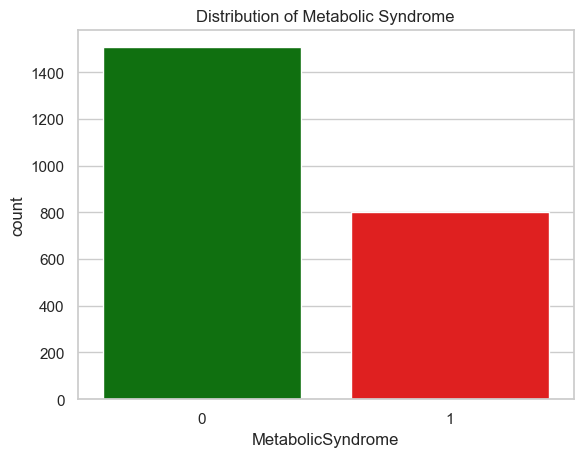

In [177]:
# Plotting the distribution of the target variable
sns.countplot(x='MetabolicSyndrome', data=data, 
              palette={'0': 'green', '1': 'red'})
plt.title('Distribution of Metabolic Syndrome')
plt.show()

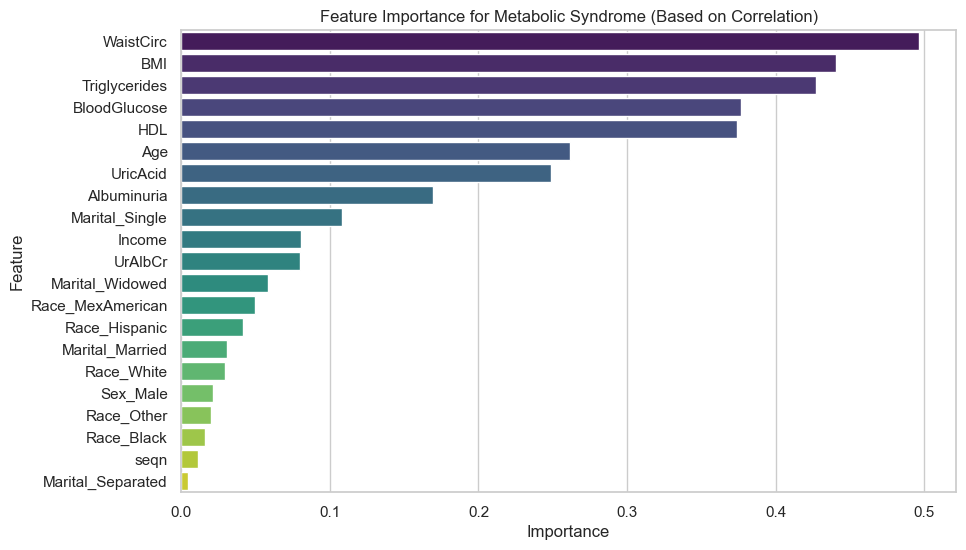

In [178]:
# Calculate the correlation of each feature with the target variable 'MetabolicSyndrome'
importances = data.corr()['MetabolicSyndrome'].drop('MetabolicSyndrome')
feature_names = importances.index

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances.abs()})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importance for Metabolic Syndrome (Based on Correlation)')
plt.show()

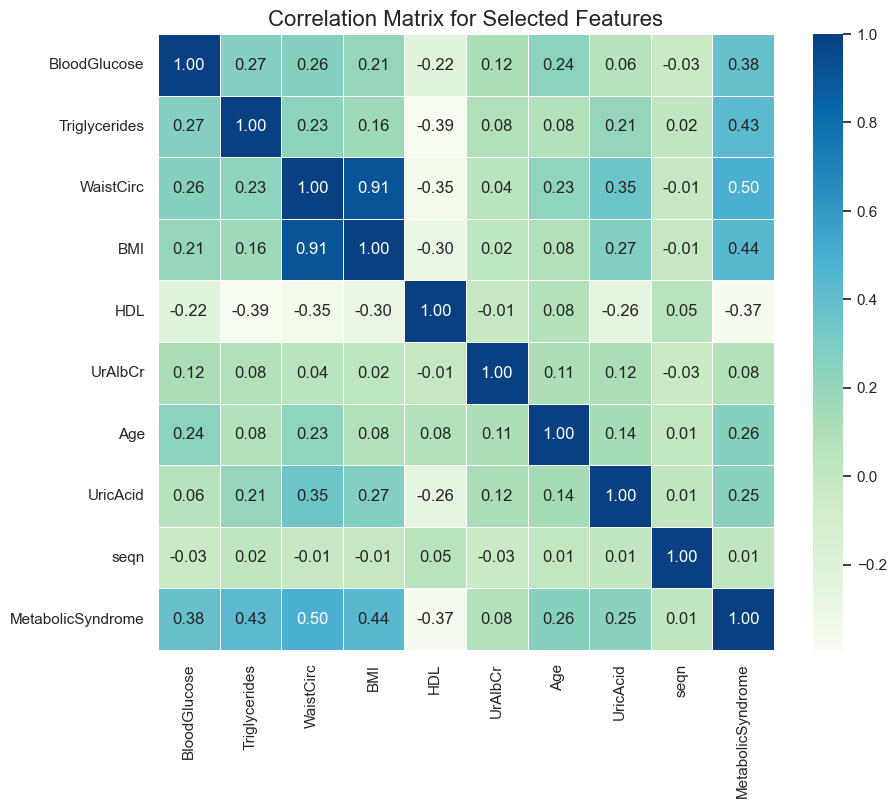

In [179]:
# Select most relevant columns for the visualisation 
selected_columns = ['BloodGlucose', 'Triglycerides', 'WaistCirc', 'BMI', 
                    'HDL', 'UrAlbCr', 'Age', 'UricAcid', 'seqn', 'MetabolicSyndrome']

# Compute the correlation matrix for the selected columns
corr_matrix = data[selected_columns].corr()

# Draw the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='GnBu', cbar=True, square=True, linewidths=.5)
plt.title('Correlation Matrix for Selected Features', fontsize=16)
plt.show()

## At first glance, it seems that Metabolic Syndrome is most linearly dependent on: 
1) Waist Circumference (0.50),
2) BMI (0.44), and
3) Triglycerides (0.43)
   
**But let's research further...** 

### Pairplot to visualize relationships between variables

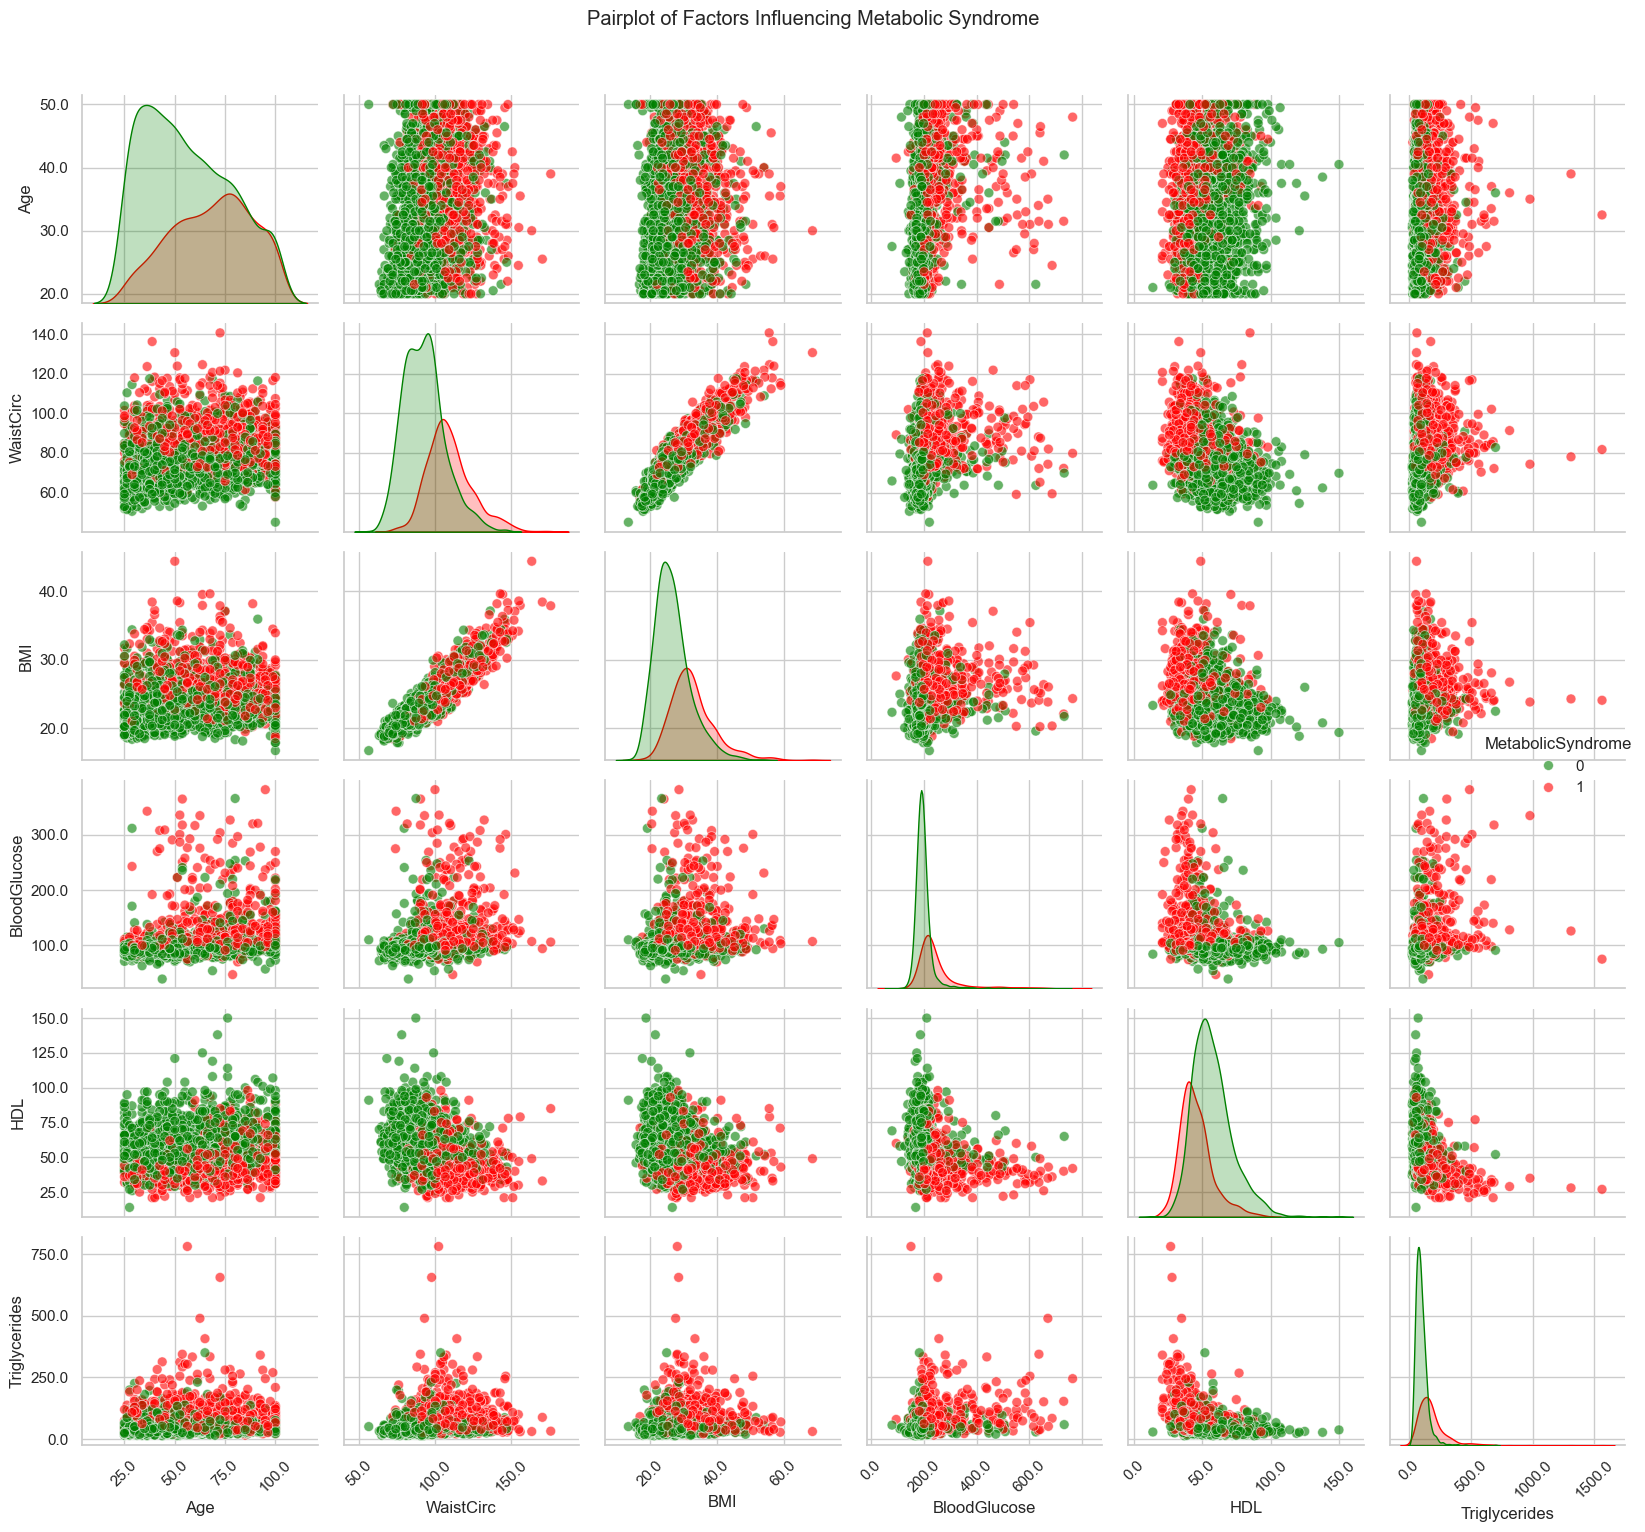

In [180]:
# Set the style and context for better readability
sns.set(style="whitegrid", context="notebook")

# Create a pairplot with smoother visuals and labeled axes
pairplot = sns.pairplot(data, 
                        vars=['Age', 'WaistCirc', 'BMI', 'BloodGlucose', 'HDL', 'Triglycerides'], 
                        hue='MetabolicSyndrome', 
                        palette={0: 'green', 1: 'red'}, 
                        diag_kind='kde',  # Kernel Density Estimate on the diagonal
                        plot_kws={'alpha': 0.6, 's': 50})  # Adjust transparency and size of the points

# Iterate through the axes to add labels
for ax in pairplot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_yticklabels(ax.get_yticks(), rotation=0)

# Improve the appearance of the plots
pairplot.fig.suptitle('Pairplot of Factors Influencing Metabolic Syndrome', y=1.02)  # Add a title
pairplot.fig.tight_layout()  # Adjust layout to fit labels
plt.show()

### We plot outliers here not to remove them from the data frame, but to visualize possible abnormal blood test conditions

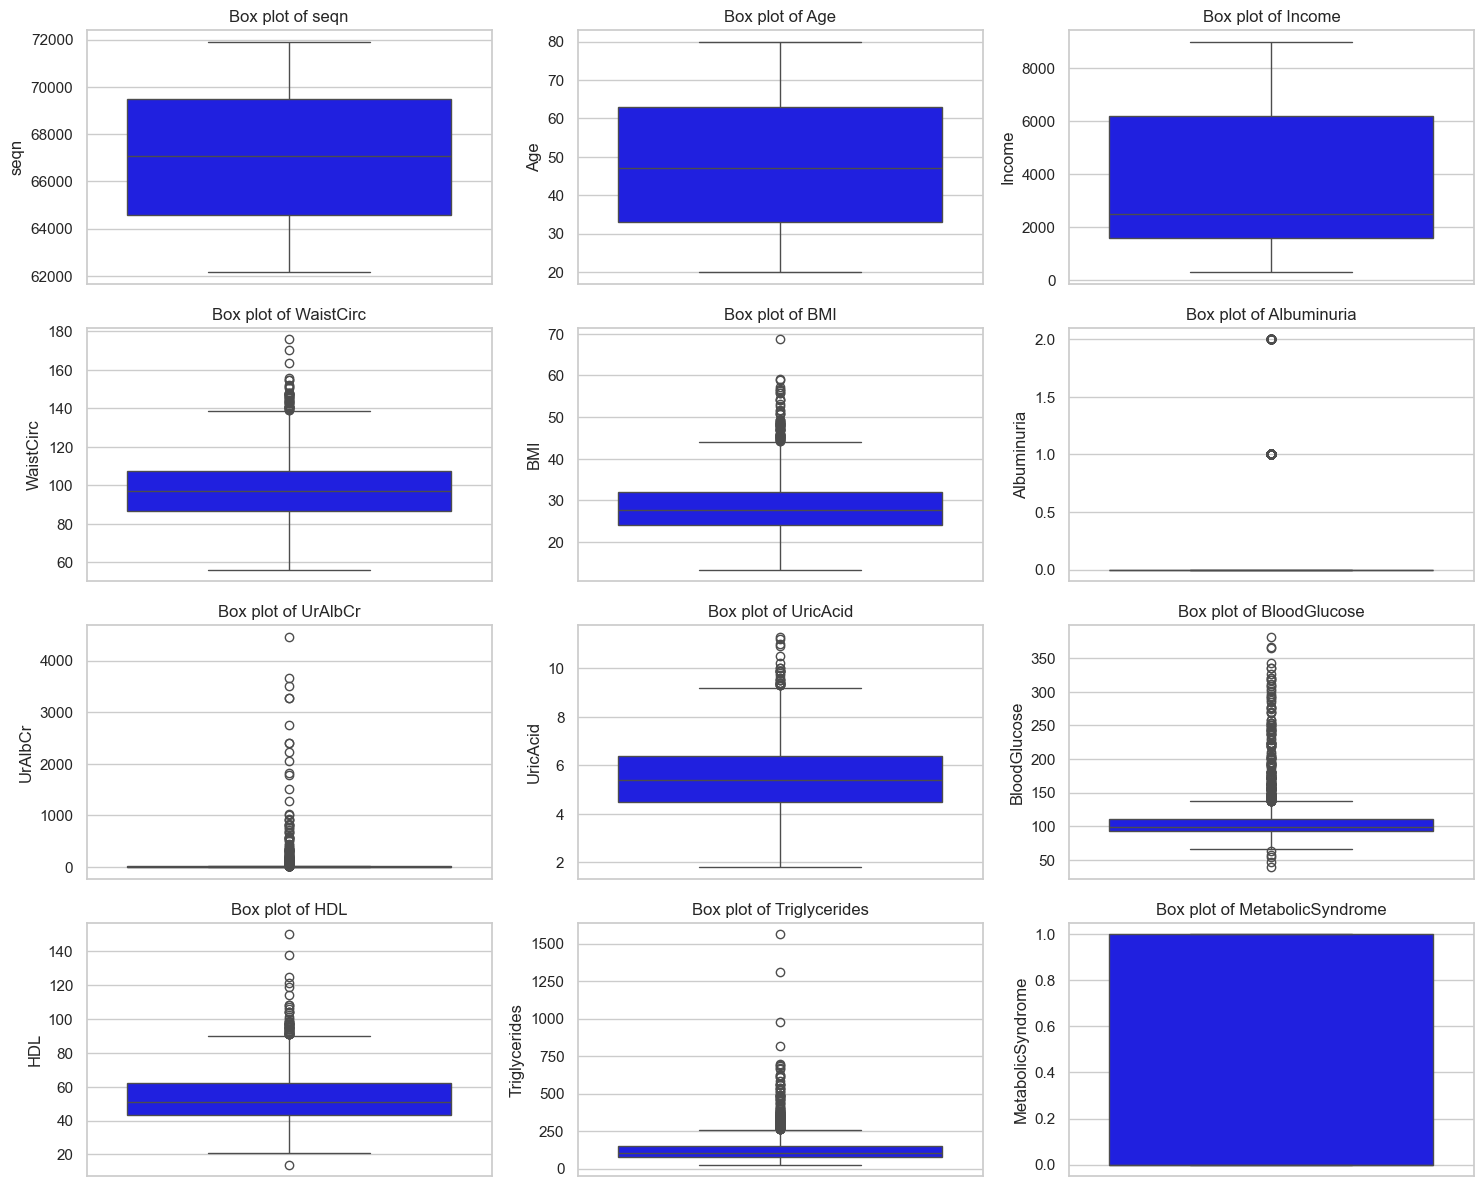

In [181]:
# Select numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Create box plots for each numerical column to visualize outliers
plt.figure(figsize=(15, 15))  # Adjust the size to fit all subplots
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i + 1)
    sns.boxplot(y=data[col], color='blue')
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

## 4. Building Machine Learning Models

## Downsampling the data for more accurate prediction

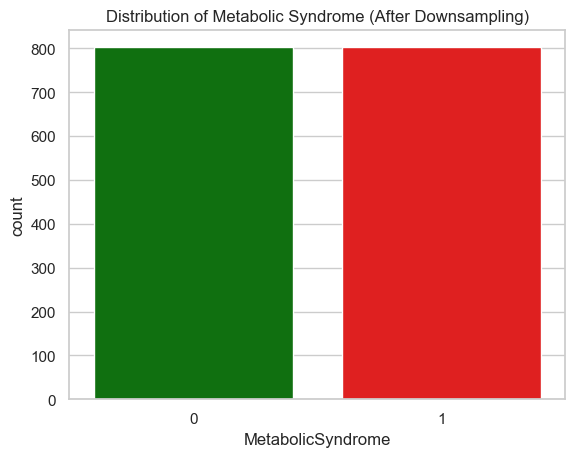

In [182]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = data[data.MetabolicSyndrome == 0]
minority_class = data[data.MetabolicSyndrome == 1]

# Downsample majority class
majority_class_downsampled = resample(majority_class, 
                                      replace=False,    # sample without replacement
                                      n_samples=len(minority_class),  # to match minority class
                                      random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
data_downsampled = pd.concat([majority_class_downsampled, minority_class])

# Display new class distribution
sns.countplot(x='MetabolicSyndrome', data=data_downsampled, 
              palette={'0': 'green', '1': 'red'})
plt.title('Distribution of Metabolic Syndrome (After Downsampling)')
plt.show()

**Logistic Regression: 0.87**

**Random Forest: 0.90**

**Support Vector Machine: 0.84**

**K-Nearest Neighbors: 0.78**

**Decision Tree: 0.86**

**Naive Bayes: 0.84**

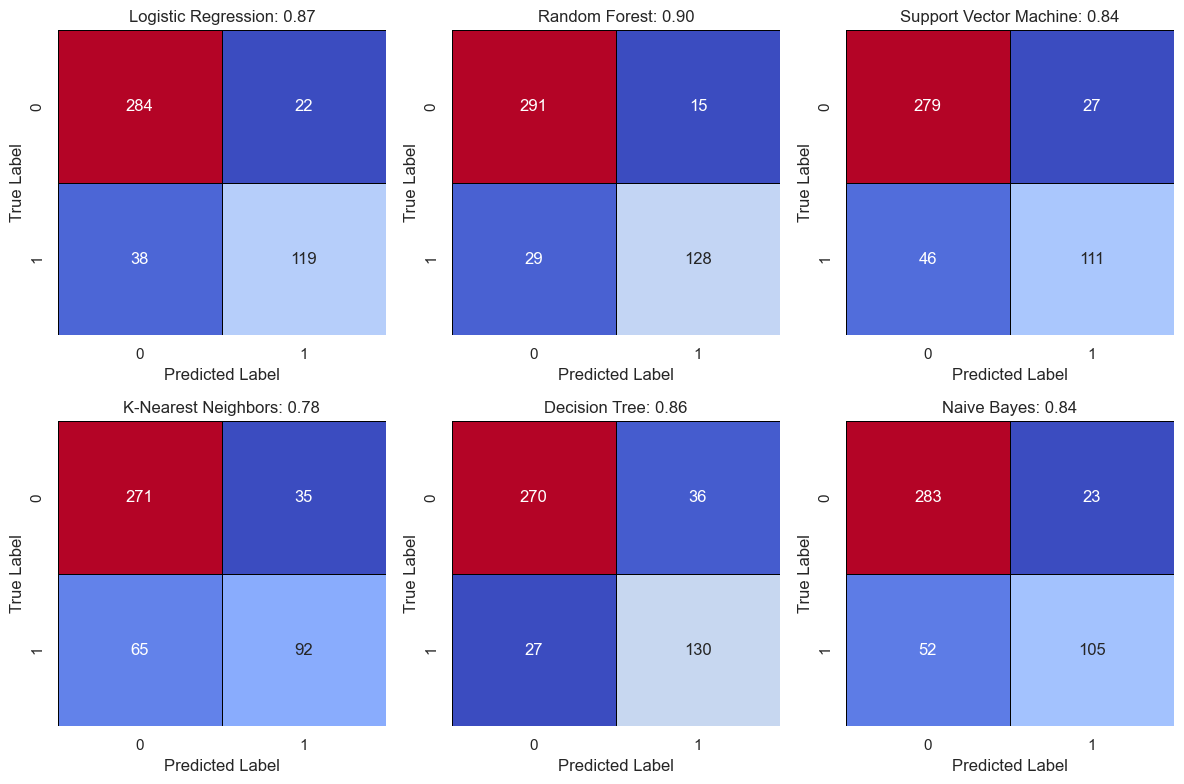

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Splitting the data into training and testing sets
X = data.drop('MetabolicSyndrome', axis=1)
y = data['MetabolicSyndrome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization of features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# List of classifiers to evaluate
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB()
}

# Display the results for each model
def print_results(i, name, accuracy, y_test, y_pred):
    display(Markdown(f"**{name}: {accuracy:.2f}**"))
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cmap = sns.color_palette("coolwarm", as_cmap=True)  
    plt.subplot(2, 3, i + 1)  # Adjusted to fit 6 plots in total (2 rows, 3 columns)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, linewidths=.5, linecolor='black')
    plt.title(f'{name}: {accuracy:.2f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# Train and evaluate each classifier
model_scores = {}
plt.figure(figsize=(12, 8))  # Adjusted figure size to fit all subplots

for i, (name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[name] = accuracy
    
    # Call the function to print and display results
    print_results(i, name, accuracy, y_test, y_pred)

plt.show()  # Show all subplots together

## 5. Model Comparison

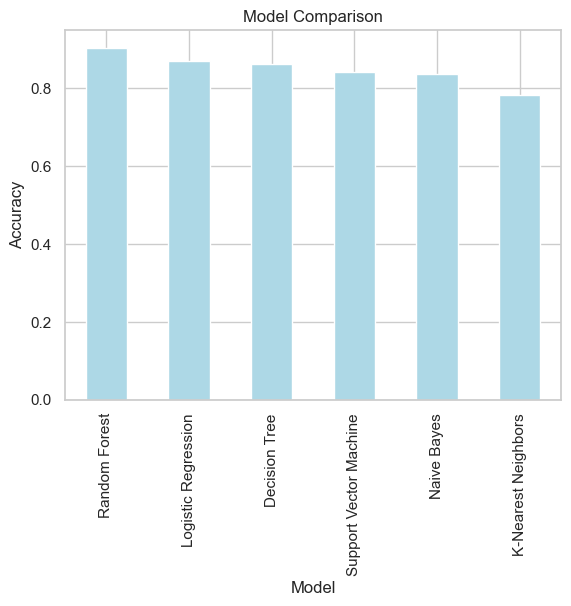

,Model,Accuracy
1,Random Forest,0.904968
0,Logistic Regression,0.870410
4,Decision Tree,0.863931
2,Support Vector Machine,0.842333
5,Naive Bayes,0.838013
3,K-Nearest Neighbors,0.784017


In [184]:
# Compare the accuracy of the models
model_scores_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Accuracy'])
model_scores_df = model_scores_df.sort_values(by='Accuracy', ascending=False)
model_scores_df.plot(kind='bar', x='Model', y='Accuracy', legend=False, color='lightblue')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

# Display the dataframe
model_scores_df

## 6. Best Model Selection

In [185]:
# Selecting the best model based on accuracy
best_model_name = model_scores_df.iloc[0]['Model']
print(f"The best model is: {best_model_name} with an accuracy of {model_scores_df.iloc[0]['Accuracy']:.2f}")


The best model is: Random Forest with an accuracy of 0.90


# 7. Feature importance visualization and Insights!

<function matplotlib.pyplot.show(close=None, block=None)>

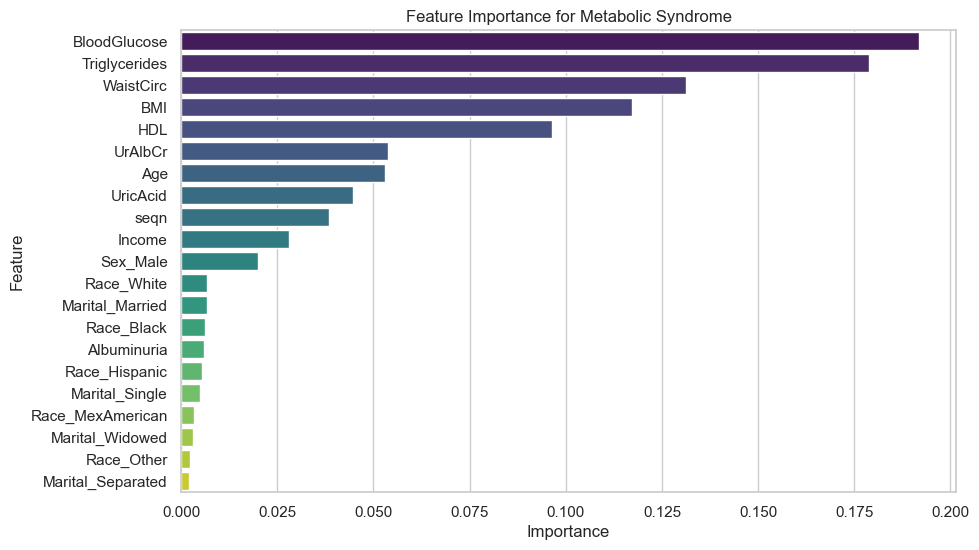

In [186]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for Metabolic Syndrome')
plt.show

## ! Here we see that the main feature was changed from Waist Circumference to Blood Glucose

**Conclusion and insight:** After downsampling the dataset and applying more accurate machine learning models, the main features have changed. Initially, Waist Circumference appeared to be the most influential factor. However, after using machine learning, Blood Glucose emerged as the key feature. This shift is likely due to the machine learning model's ability to capture complex, non-linear relationships in the data that simple correlation analysis may have missed.